#Load and Data Analysis
Importing Libraries and the Dataset from OpenML

In [62]:
from sklearn.datasets import fetch_openml
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, r2_score
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor




boston = fetch_openml(data_id=531)
X = boston.data
Y = boston.target

Creating Dataframe from the Set

In [63]:
df = pd.DataFrame(X, columns=boston.feature_names)
df['target'] = Y

Heatmap of the dataset

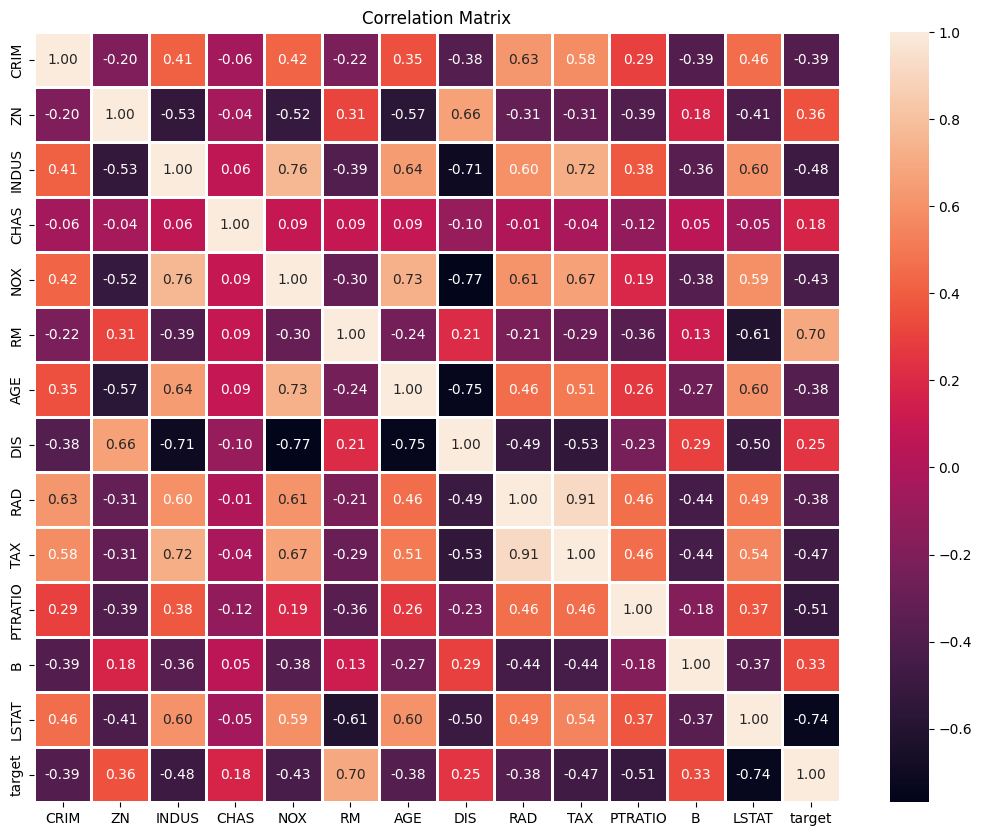

In [65]:
corr_matrix = df.corr()
plt.figure(figsize=(13, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=1)
plt.title('Correlation Matrix')
plt.show()

Pairplot of Boston Dataset

<Figure size 2500x2500 with 0 Axes>

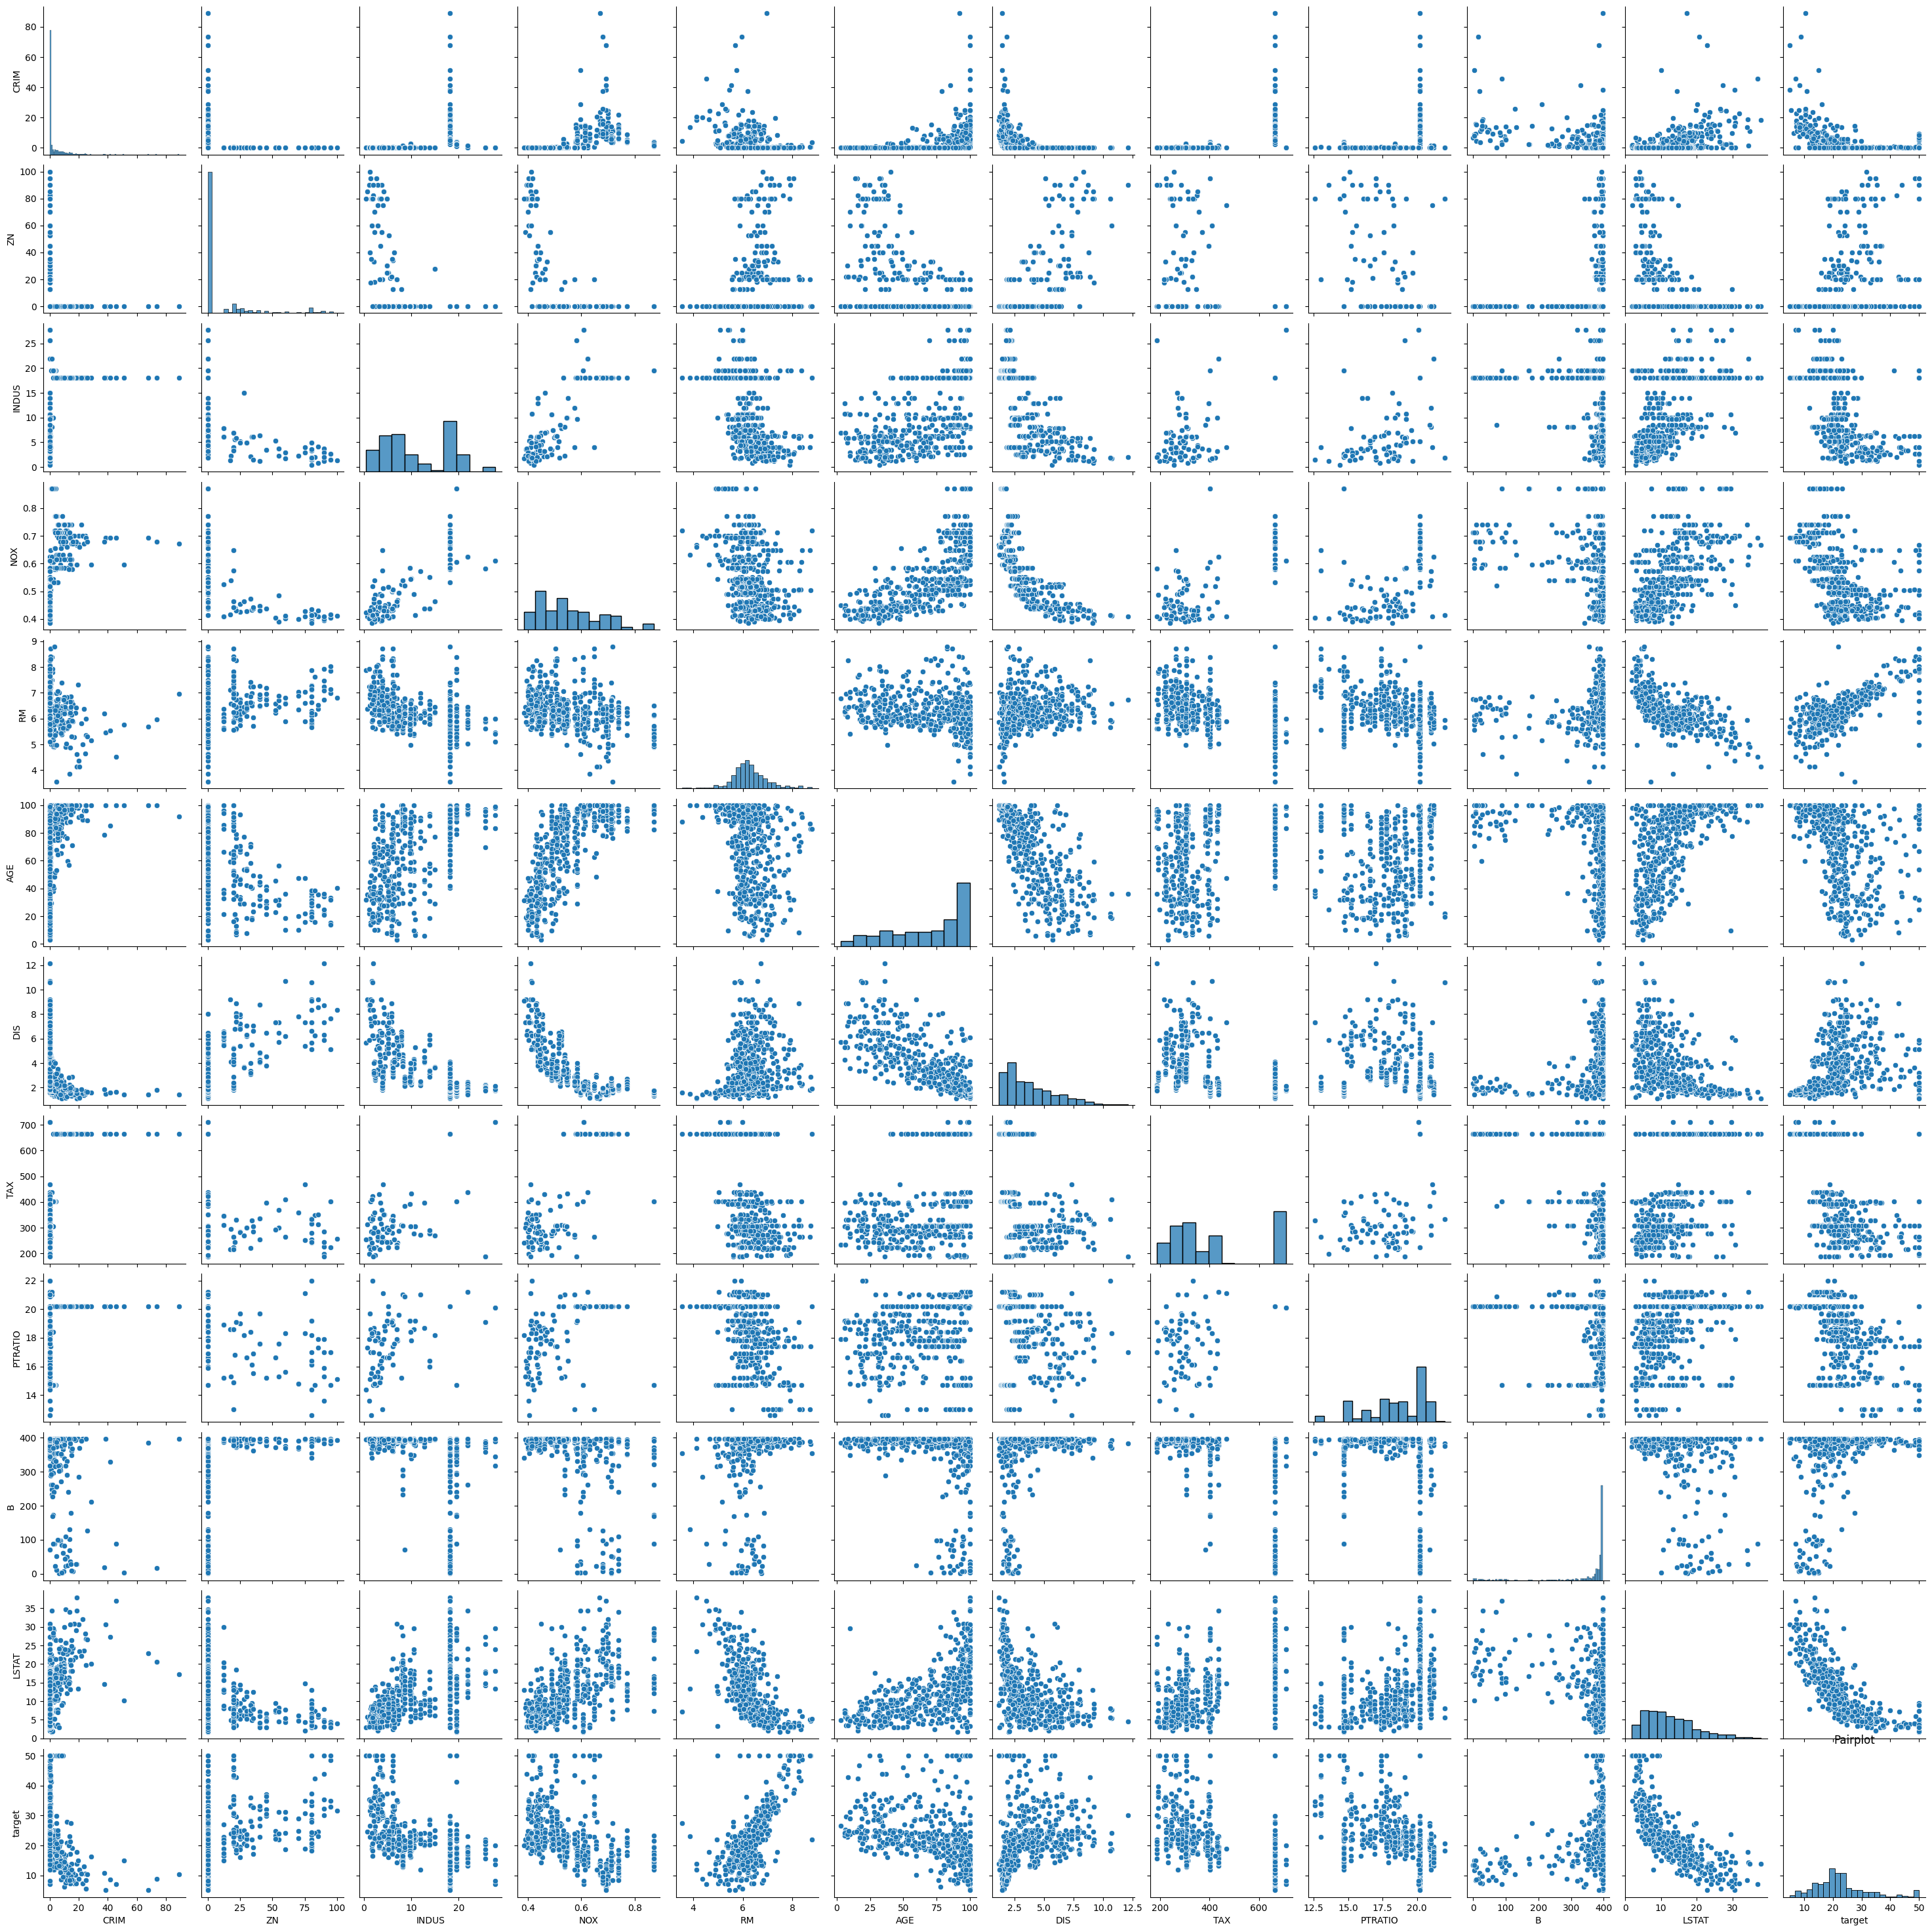

In [66]:
plt.figure(figsize=(25, 25))
sns.pairplot(df)
plt.title('Pairplot')
plt.show()

Scatter Plot for the dataset with target

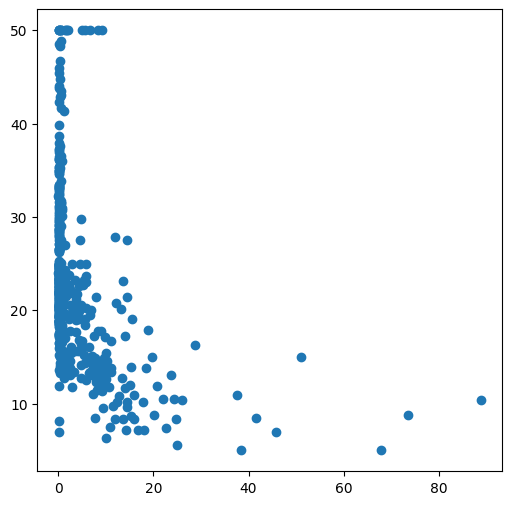

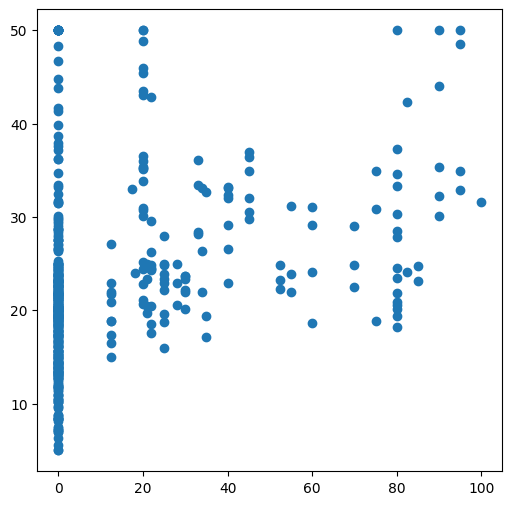

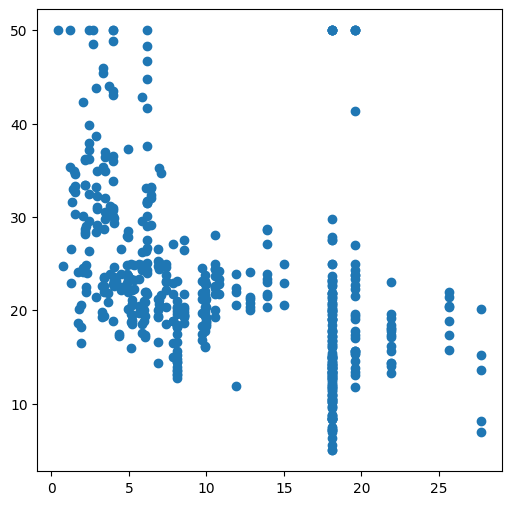

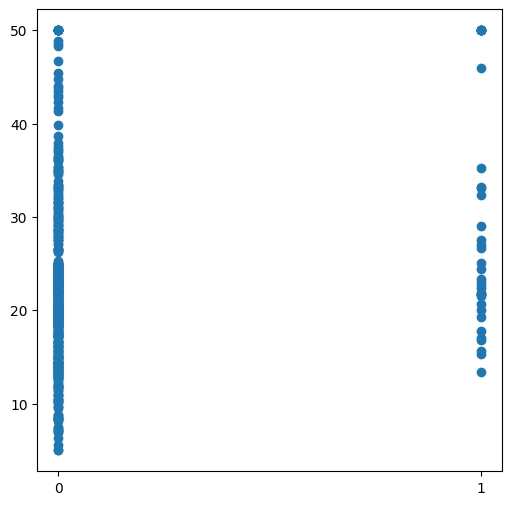

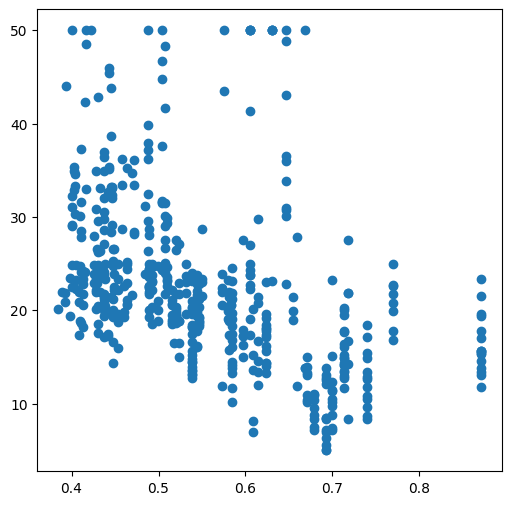

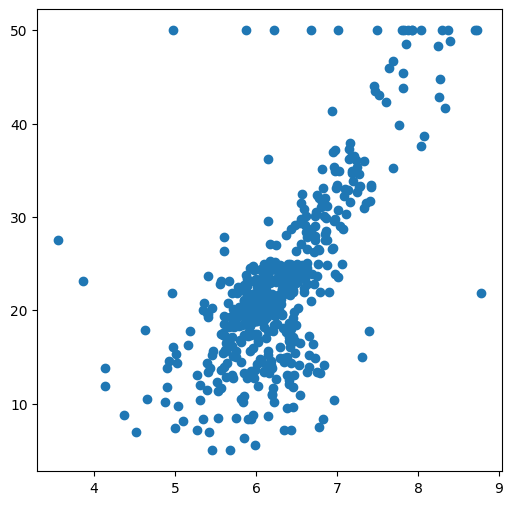

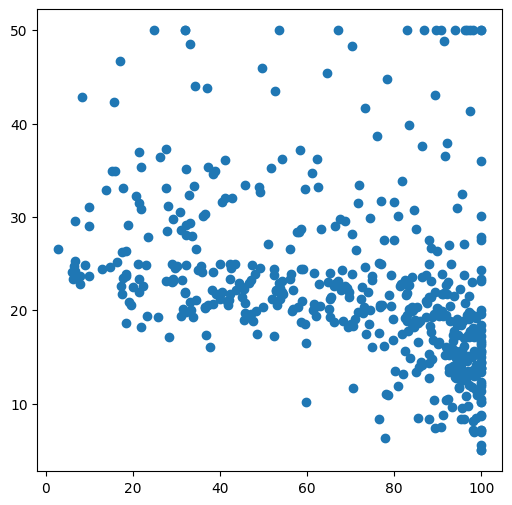

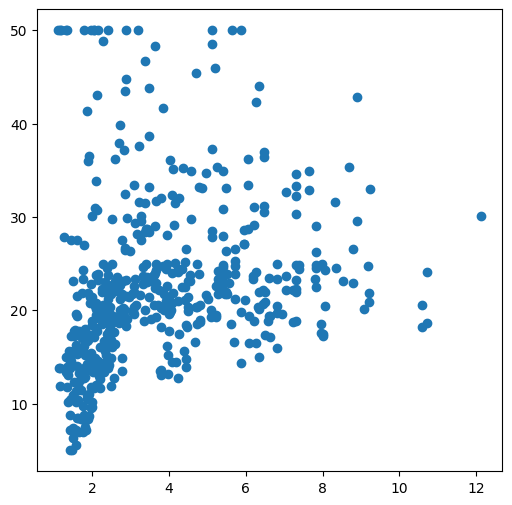

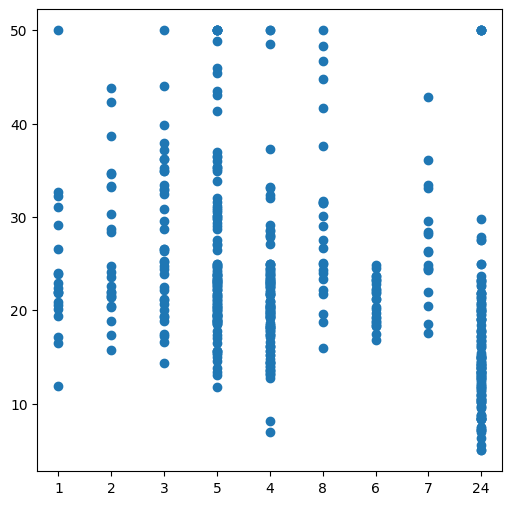

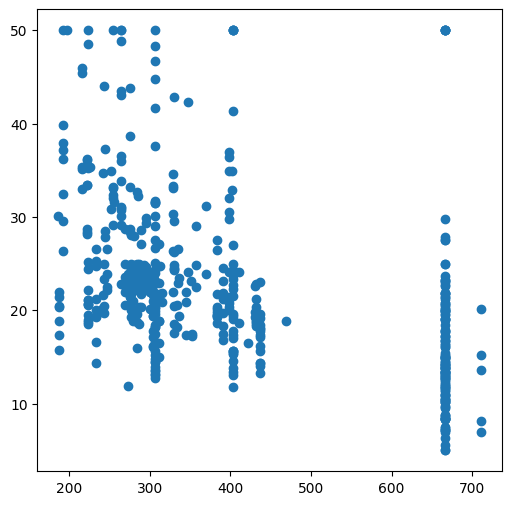

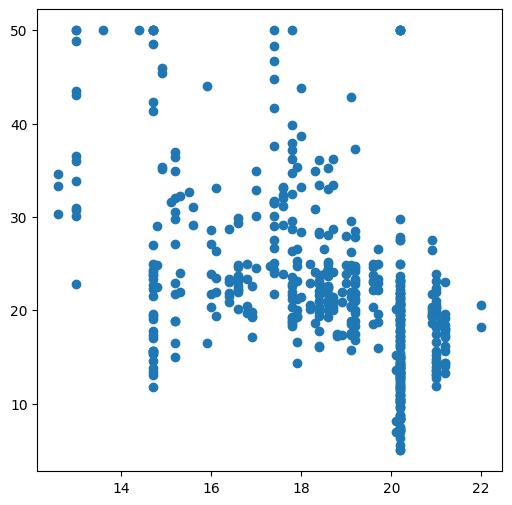

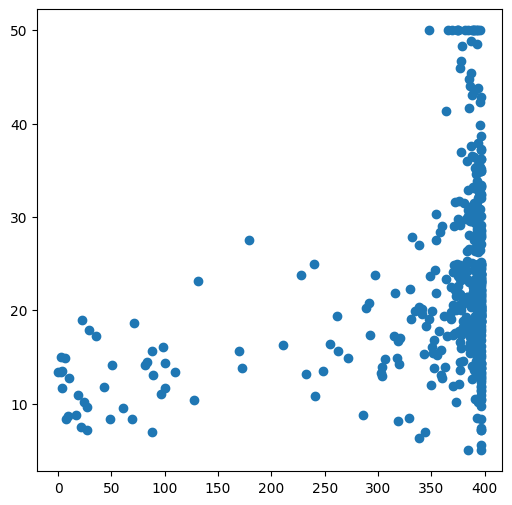

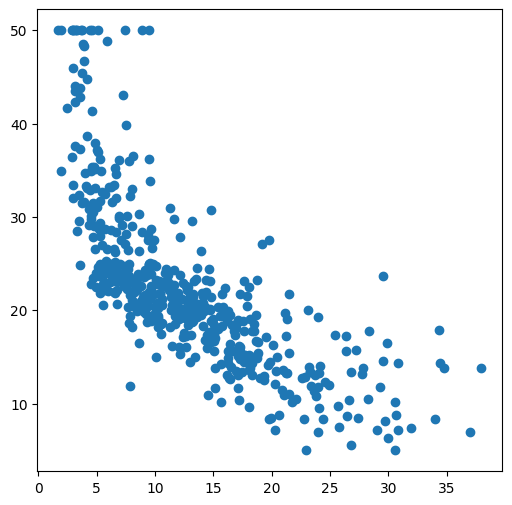

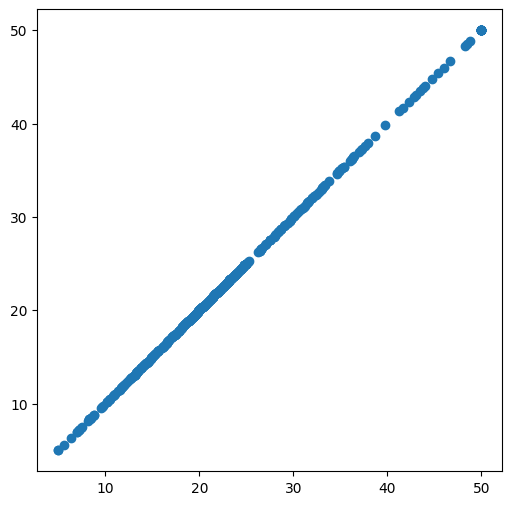

In [67]:
for x in df[:-1].columns:
  plt.figure(figsize=(6, 6))
  plt.scatter(df[x], Y)
  plt.show()

Distribution of Target (MEDV)

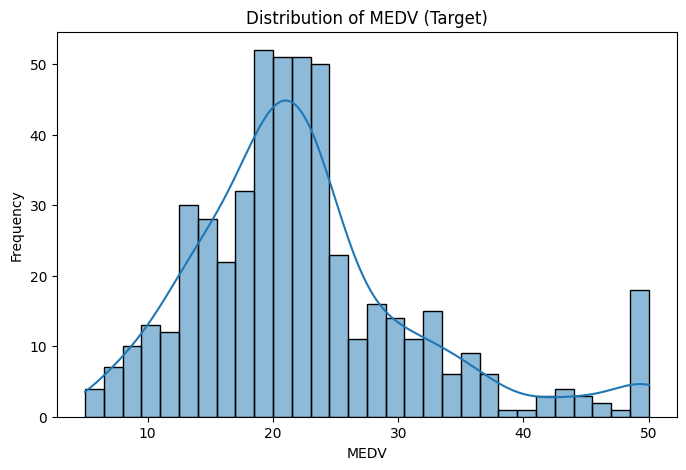

In [68]:
plt.figure(figsize=(8, 5))
sns.histplot(df['target'], bins=30, kde=True)
plt.title("Distribution of MEDV (Target)")
plt.xlabel("MEDV")
plt.ylabel("Frequency")
plt.show()

# Scaling and Splitting the data

Scaling the features from data set so they are in same range

In [78]:
scaler = preprocessing.StandardScaler()
df = scaler.fit_transform(df)
print(df)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

[[-0.41978194  0.28482986 -1.2879095  ...  0.44105193 -1.0755623
   0.15968566]
 [-0.41733926 -0.48772236 -0.59338101 ...  0.44105193 -0.49243937
  -0.10152429]
 [-0.41734159 -0.48772236 -0.59338101 ...  0.39642699 -1.2087274
   1.32424667]
 ...
 [-0.41344658 -0.48772236  0.11573841 ...  0.44105193 -0.98304761
   0.14880191]
 [-0.40776407 -0.48772236  0.11573841 ...  0.4032249  -0.86530163
  -0.0579893 ]
 [-0.41500016 -0.48772236  0.11573841 ...  0.44105193 -0.66905833
  -1.15724782]]


Splitting the data set for training and testing

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.20, random_state=42)

#Implement KNN Regressor

Defining KNN regressor with distance metrics:


*   Euclidean distance
*   Manhattan distance
*   Cosine distance






In [71]:
def euclidean_distance(x, y, p=2):
    return np.sqrt(np.sum((x - y) ** 2))

def cosine_distance(x, y):
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    if norm_x == 0 or norm_y == 0:
        return 1
    return 1 - np.dot(x, y) / (norm_x * norm_y)

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

class KNNRegressor:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.Y_train = np.array(y)

    def _compute_distances(self, x):
        if self.distance_metric == 'euclidean':
            return [euclidean_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == 'manhattan':
            return [manhattan_distance(x, x_train) for x_train in self.X_train]
        elif self.distance_metric == 'cosine':
            return [cosine_distance(x, x_train) for x_train in self.X_train]
        else:
            raise ValueError("Unsupported distance metric")

    def predict(self, X_test):
        predictions = []
        for x in X_test:
            distances = self._compute_distances(x)
            k_indices = np.argsort(distances)[:self.k]
            k_targets = self.Y_train[k_indices]
            predictions.append(np.mean(k_targets))
        return np.array(predictions)

Checking the variations in results by using different values of k.

In [72]:
results = []

k_values = [3, 5, 7, 9, 11]
distance_metrics = ['euclidean', 'manhattan', 'cosine']

for k in k_values:
    for metric in distance_metrics:
        model = KNNRegressor(k=k, distance_metric=metric)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(Y_test, y_pred)
        results.append({'k': k, 'distance_metric': metric, 'r2_score': r2})

Tabulating the results

In [73]:
results_df = pd.DataFrame(results)
results_table = results_df.pivot(index='k', columns='distance_metric', values='r2_score')
print("R² Scores for each (k, distance metric) combination:")
print(results_table.round(4))

R² Scores for each (k, distance metric) combination:
distance_metric  cosine  euclidean  manhattan
k                                            
3                0.7282     0.7225     0.7385
5                0.7080     0.7048     0.7562
7                0.6801     0.6703     0.7143
9                0.6448     0.6423     0.6888
11               0.6185     0.6460     0.6602


#Compare with scikit-learn Simple KNN

In [74]:
best_simple = results_df.loc[results_df['r2_score'].idxmax()]
best_k = best_simple['k']
best_metric = best_simple['distance_metric']
print(f"Best custom KNN: k={best_k}, metric={best_metric}, R²={best_simple['r2_score']:.4f}")


knn_sklearn = KNeighborsRegressor(
    n_neighbors=int(best_k),
    metric=best_metric,
    algorithm='brute',
    weights='uniform'
)
knn_sklearn.fit(X_train, Y_train)
y_pred_sklearn = knn_sklearn.predict(X_test)
r2_sklearn = r2_score(Y_test, y_pred_sklearn)

print(f"Sklearn KNN R²: {r2_sklearn:.4f}")


Best custom KNN: k=5, metric=manhattan, R²=0.7562
Sklearn KNN R²: 0.7562


#Implement Weighted KNN Regressor
Use weights as euclidean distance of neighbours and check R2 scores again

In [75]:
class WeightedKNNRegressor:
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric

    def fit(self, X, y):
        self.X_train = np.array(X)
        self.Y_train = np.array(y)

    def _compute_distances(self, x):
        dist_funcs = {
            'euclidean': euclidean_distance,
            'manhattan': manhattan_distance,
            'cosine': cosine_distance
        }
        return np.array([dist_funcs[self.distance_metric](x, x_train) for x_train in self.X_train])

    def predict(self, X_test):
        preds = []
        for x in X_test:
            distances = self._compute_distances(x)
            k_indices = np.argsort(distances)[:self.k]
            k_distances = distances[k_indices]
            k_targets = self.Y_train[k_indices]

            weights = np.where(k_distances == 0, 1e9, 1 / k_distances)
            weighted_avg = np.dot(weights, k_targets) / np.sum(weights)
            preds.append(weighted_avg)
        return np.array(preds)


weighted_results = []
for k in k_values:
    for metric in distance_metrics:
        model = WeightedKNNRegressor(k=k, distance_metric=metric)
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(Y_test, y_pred)
        weighted_results.append({'k': k, 'distance_metric': metric, 'r2_score': r2})

weighted_knn_results = pd.DataFrame(weighted_results)
print(weighted_knn_results)

     k distance_metric  r2_score
0    3       euclidean  0.742211
1    3       manhattan  0.746492
2    3          cosine  0.749172
3    5       euclidean  0.729076
4    5       manhattan  0.771096
5    5          cosine  0.746169
6    7       euclidean  0.701567
7    7       manhattan  0.736656
8    7          cosine  0.731720
9    9       euclidean  0.679156
10   9       manhattan  0.718274
11   9          cosine  0.713526
12  11       euclidean  0.681076
13  11       manhattan  0.692546
14  11          cosine  0.696211


#Compare with scikit-learn Weighted KNN
Check R2 scores from both and compare

In [76]:
best_weighted = weighted_knn_results.loc[weighted_knn_results['r2_score'].idxmax()]
best_k_w = best_weighted['k']
best_metric_w = best_weighted['distance_metric']


knn_weighted_sklearn = KNeighborsRegressor(
    n_neighbors=int(best_k_w),
    metric=best_metric_w,
    algorithm='brute',
    weights='distance'
)
knn_weighted_sklearn.fit(X_train, Y_train)
y_pred_weighted_sklearn = knn_weighted_sklearn.predict(X_test)
r2_weighted_sklearn = r2_score(Y_test, y_pred_weighted_sklearn)

print(f"Best custom weighted KNN: k={best_k_w}, metric={best_metric_w}, R²={best_weighted['r2_score']:.4f}")
print(f"Sklearn weighted KNN R²: {r2_weighted_sklearn:.4f}")


Best custom weighted KNN: k=5, metric=manhattan, R²=0.7711
Sklearn weighted KNN R²: 0.7711


#Reporting and Visualization

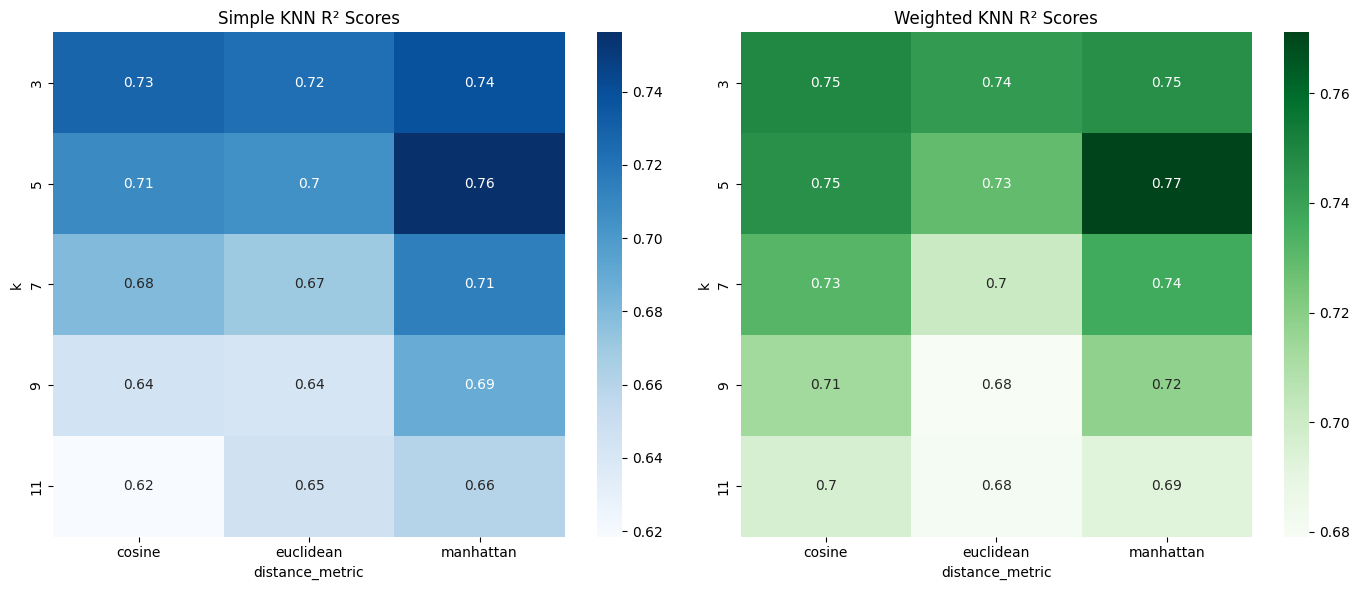

In [80]:
pivot_simple = results_df.pivot(index='k', columns='distance_metric', values='r2_score')
pivot_weighted = weighted_knn_results.pivot(index='k', columns='distance_metric', values='r2_score')

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(pivot_simple, annot=True, cmap='Blues', ax=axs[0])
axs[0].set_title("Simple KNN R² Scores")

sns.heatmap(pivot_weighted, annot=True, cmap='Greens', ax=axs[1])
axs[1].set_title("Weighted KNN R² Scores")

plt.tight_layout()
plt.show()




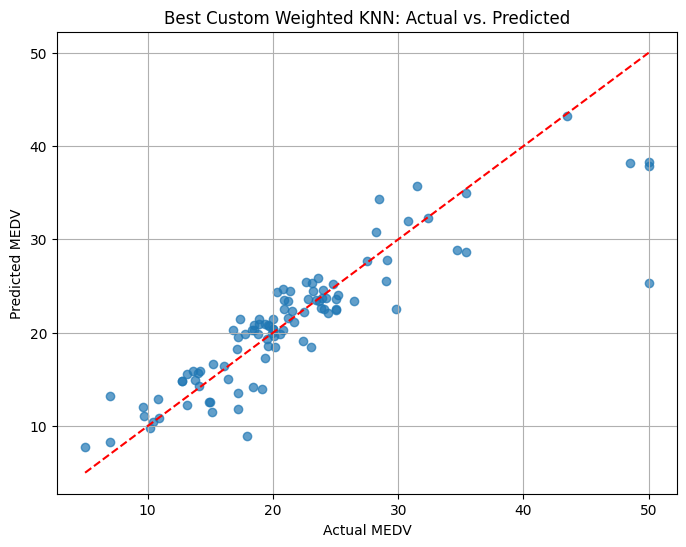

In [79]:
best_model = WeightedKNNRegressor(k=int(best_k_w), distance_metric=best_metric_w)
best_model.fit(X_train, Y_train)
y_pred_best_custom = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_pred_best_custom, alpha=0.7)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Best Custom Weighted KNN: Actual vs. Predicted")
plt.grid(True)
plt.show()

##  Summary of Findings

###  Best Performing (k, distance metric):

From the `weighted_knn_results`, the best custom model was:

- **k = `5`**  
- **Distance Metric = `manhattan`**  
- **R² Score = `0.7711`**


---

###  Comparison with scikit-learn:

- **Custom KNN (Weighted):**  
  - R² = `0.7711`
  
- **Scikit-learn KNN (Weighted):**  
  - R² = `0.7711`

 The R² score of the custom weighted KNN implementation is equal to that of scikit-learn’s, indicating correct distance calculation, sorting, and weighting logic.

---

